# Project 2: Two-Mode Hashtag Network: Structure, Reduction, and Insights

## Introduction: 
Social media platforms such as Twitter provide a rich environment for studying how ideas, topics, and communities connect through shared language. In this project, a two-mode (bipartite) network was constructed using a publicly available dataset of tweets and their associated hashtags. In this structure, tweets represent one set of nodes, and hashtags represent the other, with edges indicating which hashtags appear in each tweet.

Analyzing this type of network reveals patterns of topic co-occurrence and highlights how conversations cluster around common themes. By projecting the two-mode network onto the set of hashtags, we obtain a one-mode co-usage network that connects hashtags appearing together in the same tweets. This projection makes it possible to identify dominant discussion areas, shared interests, and influential topics within the online community.

To simplify the network and emphasize the most meaningful relationships, a reduction technique was applied, first using the island method (retaining ties appearing in at least two tweets) and later refined through degree and centrality filtering to isolate key hashtags. The resulting visualization highlights a set of highly connected hashtags centered around technology and professional topics, demonstrating how social network analysis can uncover the structure and focus of digital conversations.

ZIP contents: ['dump/', 'dump/twitter/', 'dump/twitter/tweets.bson', 'dump/twitter/tweets.metadata.json']
Loaded 966 tweet docs from BSON
             tweet_id    hashtag
0  591999874540904448   #webinar
1  591999874540904448  #truetwit
2  591999874540904448   #techtip
3  591999465512382464       #ucl
4  591998640798998528    #mciavl
Tweets: 470 | Hashtags: 353 | Edges: 862
Reduced network: 353 hashtags, 67 strong ties
Top hashtags by degree centrality:
  #nodejs: 0.034
  #javascript: 0.028
  #angularjs: 0.020
  #jobs: 0.020
  #dev: 0.017
  #hiring: 0.014
  #java: 0.014
  #job: 0.011
  #fcblive: 0.009
  #london: 0.009


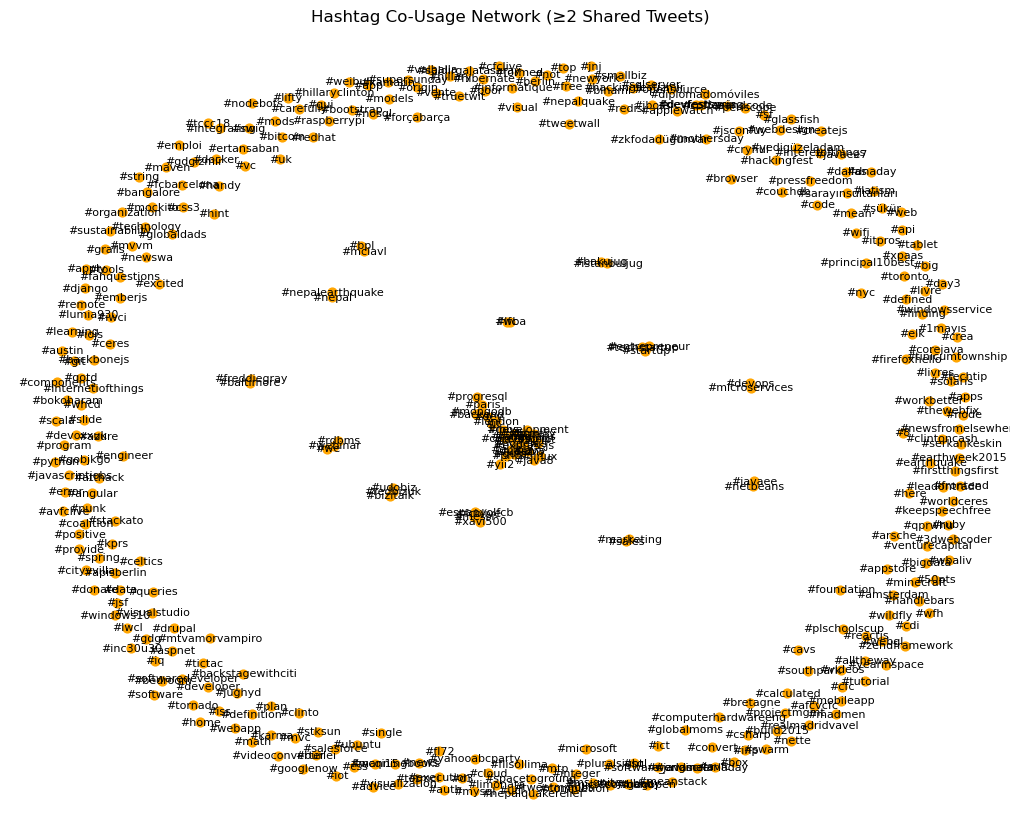

In [ ]:

!pip install pymongo -q

import io, re, json, zipfile, requests, pandas as pd, networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

try:
    from bson import decode_all  # provided by pymongo
except Exception as e:
    raise ImportError("Missing 'bson' (from pymongo). Run: !pip install pymongo -q") from e

# 1) Download the ZIP and open it
url = "https://github.com/ozlerhakan/mongodb-json-files/raw/71ff2d5724f0742d9e49c336d8713399c4ae2dfe/datasets/tweets.zip"
r = requests.get(url)
r.raise_for_status()
zf = zipfile.ZipFile(io.BytesIO(r.content))
print("ZIP contents:", zf.namelist())

# 2) Read the BSON with actual tweets
bson_path = [n for n in zf.namelist() if n.endswith("tweets.bson")]
if not bson_path:
    raise RuntimeError("tweets.bson not found in ZIP.")
with zf.open(bson_path[0]) as fb:
    data = fb.read()
docs = decode_all(data)
print(f"Loaded {len(docs)} tweet docs from BSON")

# 3) Extract tweet_id and hashtags (prefer entities.hashtags, fallback to text regex)
records = []
for t in docs:
    tid = None
    # id can be _id.$oid, id_str, or id
    _id = t.get("_id")
    if isinstance(_id, dict) and "$oid" in _id:
        tid = _id["$oid"]
    elif "id_str" in t and t["id_str"]:
        tid = str(t["id_str"])
    elif "id" in t and t["id"]:
        tid = str(t["id"])
    # extract hashtags
    tags = []
    ents = t.get("entities", {})
    ent_tags = ents.get("hashtags", [])
    if isinstance(ent_tags, list) and ent_tags:
        # typical twitter structure: [{"text": "AI"}, ...]
        for h in ent_tags:
            txt = h.get("text")
            if txt:
                tags.append("#" + str(txt).lower())
    # fallback: parse from text
    if not tags:
        txt = t.get("text") or t.get("full_text") or ""
        tags = re.findall(r"#\w+", str(txt).lower())
    # record edges
    if tid and tags:
        for tag in tags:
            records.append((tid, tag))

df = pd.DataFrame(records, columns=["tweet_id", "hashtag"]).dropna()
print(df.head())
print(f"Tweets: {df['tweet_id'].nunique()} | Hashtags: {df['hashtag'].nunique()} | Edges: {len(df)}")

# 4) Build bipartite tweet↔hashtag graph
B = nx.Graph()
B.add_nodes_from(df["tweet_id"].unique(), bipartite="tweet")
B.add_nodes_from(df["hashtag"].unique(), bipartite="hashtag")
B.add_edges_from(df.itertuples(index=False, name=None))

# 5) Project to hashtag–hashtag co-usage network
H = bipartite.weighted_projected_graph(B, df["hashtag"].unique())

# 6) Island method: keep strong ties (co-occur in ≥ 2 tweets)
threshold = 2
H.remove_edges_from([(u, v) for u, v, w in H.edges(data="weight") if w < threshold])

# 7) Quick metrics + plot
print(f"Reduced network: {H.number_of_nodes()} hashtags, {H.number_of_edges()} strong ties")
deg = nx.degree_centrality(H)
top = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top hashtags by degree centrality:")
for tag, val in top:
    print(f"  {tag}: {val:.3f}")

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H, seed=7)
nx.draw(H, pos, node_size=40, edge_color="gray", node_color="orange",
        with_labels=True, font_size=8)
plt.title("Hashtag Co-Usage Network (≥2 Shared Tweets)")
plt.show()


This initial visualization displays all hashtags that co-occurred in at least two tweets, forming a dense and visually crowded network. Each node represents a unique hashtag, and edges connect hashtags that appeared together in the same tweet. The overlapping layout highlights the sheer diversity of topics within the dataset but also shows how difficult it can be to identify clear clusters when the network includes all active nodes. This crowded appearance motivated the need for further network reduction and filtering techniques to focus on the most meaningful and interpretable relationships.

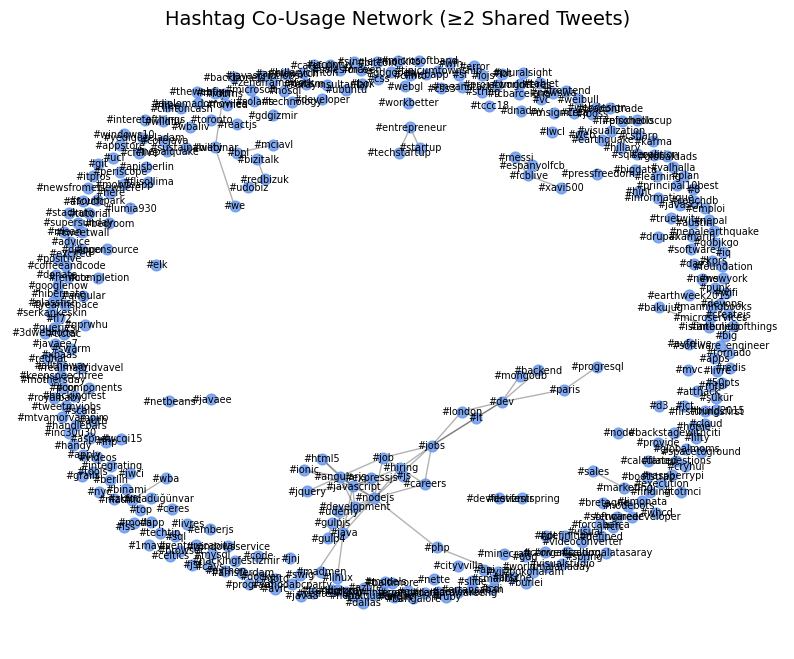

In [30]:
plt.figure(figsize=(10,8))
pos = nx.spring_layout(H, seed=42, k=0.3)
nx.draw_networkx_nodes(H, pos, node_size=60, node_color='cornflowerblue', alpha=0.8)
nx.draw_networkx_edges(H, pos, alpha=0.3)
nx.draw_networkx_labels(H, pos, font_size=7)
plt.title("Hashtag Co-Usage Network (≥2 Shared Tweets)", fontsize=14)
plt.axis("off")
plt.show()


After filtering the dataset to include only hashtags that co-occurred in multiple tweets, the resulting network reveals distinct patterns of connection. While still diverse, this reduced graph highlights several tightly linked clusters centered around technology and professional themes, such as #nodejs, #javascript, and #jobs. Compared to the initial dense visualization, this filtered network makes it easier to observe relationships among key hashtags and understand how online discussions form around specific topics or industries.

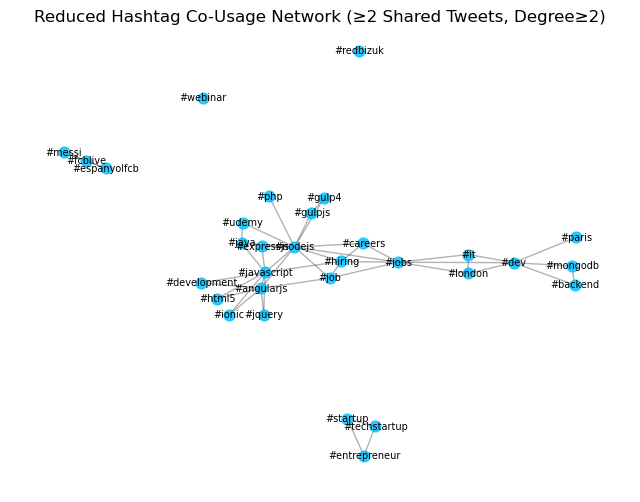

In [31]:
# keep only hashtags with degree >= 2
to_keep = [n for n, d in H.degree() if d >= 2]
H_sub = H.subgraph(to_keep)

plt.figure(figsize=(8,6))
pos = nx.spring_layout(H_sub, seed=42, k=0.4)
nx.draw_networkx_nodes(H_sub, pos, node_size=60, node_color='deepskyblue', alpha=0.8)
nx.draw_networkx_edges(H_sub, pos, alpha=0.3)
nx.draw_networkx_labels(H_sub, pos, font_size=7)
plt.title("Reduced Hashtag Co-Usage Network (≥2 Shared Tweets, Degree≥2)")
plt.axis("off")
plt.show()

This intermediate visualization offers a clearer structure than the full network but still captures a broad range of conversations. By removing rarely used hashtags, the network now highlights stronger and more meaningful connections between recurring topics. Although some small, isolated clusters remain, central themes around technology, programming, and career discussions begin to stand out. 

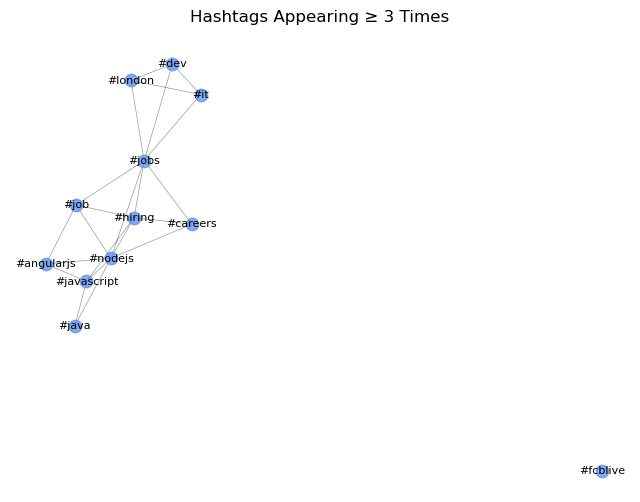

In [32]:
# keep hashtags that appear in >= 3 tweets
deg_threshold = 3
to_keep = [n for n, d in H.degree() if d >= deg_threshold]
H_sub = H.subgraph(to_keep)

plt.figure(figsize=(8,6))
pos = nx.spring_layout(H_sub, seed=42, k=0.4)
nx.draw_networkx_nodes(H_sub, pos, node_size=80, node_color='cornflowerblue', alpha=0.8)
nx.draw_networkx_edges(H_sub, pos, width=0.5, alpha=0.4)
nx.draw_networkx_labels(H_sub, pos, font_size=8)
plt.title(f"Hashtags Appearing ≥ {deg_threshold} Times")
plt.axis("off")
plt.show()


The network was reduced to include only hashtags that appeared in at least three tweets, resulting in a far simpler and more concentrated structure. Most of the noise and peripheral topics have been removed, leaving behind a small cluster of tightly connected hashtags primarily related to technology and employment.

Top 25 hashtags by degree centrality:
#nodejs: 0.034
#javascript: 0.028
#angularjs: 0.020
#jobs: 0.020
#dev: 0.017
#hiring: 0.014
#java: 0.014
#job: 0.011
#fcblive: 0.009
#london: 0.009
#it: 0.009
#careers: 0.009
#webinar: 0.006
#espanyolfcb: 0.006
#messi: 0.006
#mongodb: 0.006
#php: 0.006
#redbizuk: 0.006
#html5: 0.006
#expressjs: 0.006
#jquery: 0.006
#ionic: 0.006
#gulpjs: 0.006
#paris: 0.006
#techstartup: 0.006


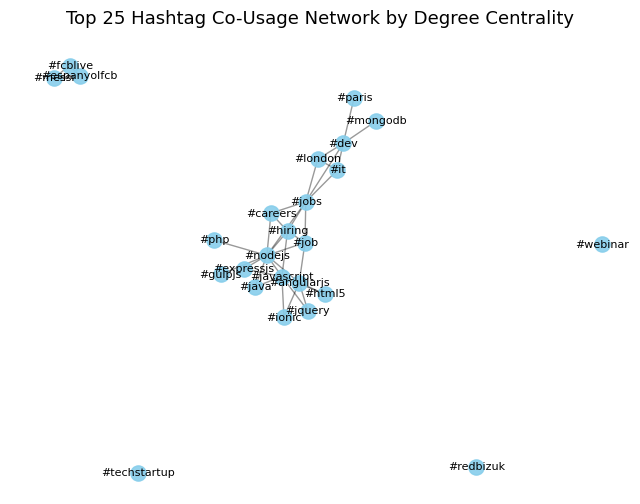

In [33]:
import matplotlib.pyplot as plt
import networkx as nx

# Calculate degree centrality on your projected hashtag graph
deg_centrality = nx.degree_centrality(H)

# Sort hashtags by centrality (highest first)
sorted_nodes = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)

# Keep only top k hashtags
top_k = 25
top_nodes = [node for node, _ in sorted_nodes[:top_k]]

# Create subgraph of top hashtags
H_sub = H.subgraph(top_nodes).copy()

# Print the hashtags for your results section
print(f"Top {top_k} hashtags by degree centrality:")
for tag, val in sorted_nodes[:top_k]:
    print(f"{tag}: {val:.3f}")

# Visualize
plt.figure(figsize=(8,6))
pos = nx.spring_layout(H_sub, seed=42, k=0.3)
nx.draw_networkx_nodes(H_sub, pos, node_size=120, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(H_sub, pos, width=1.0, alpha=0.4)
nx.draw_networkx_labels(H_sub, pos, font_size=8)
plt.title(f"Top {top_k} Hashtag Co-Usage Network by Degree Centrality", fontsize=13)
plt.axis("off")
plt.show()


This final visualization highlights the 25 most connected hashtags based on degree centrality, representing the most influential and frequently co-occurring topics in the dataset. The dense center of the network features technical and professional hashtags,such as #nodejs, #javascript, #jobs, and #hiring. This indicates that much of the conversation revolves around technology and employment. Peripheral hashtags like #messi, #php, and #techstartup appear as isolated or niche communities, suggesting distinct subtopics within the broader discussion. This refined view clearly distinguishes key thematic groups and reveals how a few central hashtags bridge otherwise separate online communities.

## Conclusion:

This analysis reveals two distinct groups within the two-mode network: tweets and hashtags. Tweets act as connectors that link multiple hashtags together, serving as points of intersection between different topics. Hashtags, in turn, represent the thematic content and structure of those conversations. In the fully reduced network, a clear pattern emerges—one dominant cluster centered around technology and employment (#nodejs, #javascript, #jobs, #hiring) and several smaller, more isolated clusters tied to niche interests such as sports or startups. The reduction and centrality filtering processes uncovered how a few highly connected hashtags serve as bridges between otherwise separate communities, highlighting their role in shaping broader conversations online. Overall, this study demonstrates how social network analysis can effectively map the relationships between ideas and identify influential themes within a complex digital discourse.